# Methods

## Data Preprocessing

### Text Cleaning and Normalization
1. **Lowercasing**: Convert all text to lowercase to standardize spelling variants.
2. **Removing Punctuation/Special Characters**: Eliminate noise from symbols and punctuation.
3. **Tokenization**: Segment text into tokens (words/symbols) using NLTK.
4. **Stop Word Removal**: Drop high-frequency, low-information words (e.g., "the", "and").
5. **Lemmatization**: Reduce words to base forms (e.g., "running" → "run") to group variants.

### Handling Class Imbalance
- **Oversampling (SMOTE)**: Generate synthetic samples for the minority (fraudulent) class to balance the dataset.

---

## Feature Extraction

### Bag-of-Words (BoW)
- **Unigram Model**: Represent text as token counts (or binary presence/absence).
- **Bigrams (where applicable)**: Capture two-word phrases for contextual patterns.

### TF-IDF (Term Frequency-Inverse Document Frequency)
- Weight terms by their frequency in a document vs. rarity in the dataset.
- **Unigrams + Bigrams**: Highlight discriminative terms (e.g., "scam", "urgent").

---

## Model Selection

### Primary Model: Multinomial Naïve Bayes (MNB)
- **Implementation**: Scikit-learn’s `MultinomialNB`.
- **Smoothing (Laplace)**: Handle zero probabilities with `α = 1`.

### Baseline Comparisons
1. **Logistic Regression**:
   - Linear model with default regularization (`C=1`).
   - Max iterations: 1000.
2. **Neural Network**:
   - 4-layer architecture (ReLU activations + sigmoid output).
   - Optimizer: Adam.
   - Early stopping (patience=3).
   - Class weights for imbalance.

---

## Training and Validation

### Data Partitioning
- **Split**: 80% training, 20% test (stratified to maintain class distribution).

### Cross-Validation
- **k-Fold (k=5)**: Train on 4 folds, validate on 1; average metrics across folds.

### Hyperparameters
- **Naïve Bayes**: `α = 1` (Laplace smoothing).
- **Logistic Regression**: `C=1`, max iterations = 1000.
- **Neural Network**: Class-weighted loss, early stopping.

---

## Evaluation Metrics
- **Primary Metrics**:
  - Accuracy, Precision, Recall, F1 Score.
  - Confusion Matrix (focus on minimizing false negatives).
- **Focus**: High recall to reduce missed fraud cases.

In [ ]:
# Install dependencies as needed:
%pip install kagglehub[pandas-datasets]
%pip install imbalanced-learn
%pip install nltk
%pip install tensorflow
%pip install keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Imports

In [ ]:
import kagglehub
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


C:\Users\Aamid Mohsin\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to C:\Users\Aamid
[nltk_data]     Mohsin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aamid
[nltk_data]     Mohsin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Aamid
[nltk_data]     Mohsin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Read CSV

In [4]:
path = "../data/raw/"
data = pd.read_csv(path + "DataSet.csv")

Basic EDA

In [5]:
# analyze the dataset
print('dataset shape:', data.shape)
print('dataset info:')
print(data.info())

dataset shape: (17880, 18)
dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17880 non-null  object
 6   requirements         15191 non-null  object
 7   benefits             10684 non-null  object
 8   telecommuting        17880 non-null  object
 9   has_company_logo     17880 non-null  object
 10  has_questions        17880 non-null  object
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function    

In [6]:
print('null value count:')
print(data.isnull().sum())

null value count:
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                0
requirements            2689
benefits                7196
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
in_balanced_dataset        0
dtype: int64


Cleaning Dataset

In [7]:
def htmlparser(text):
    text = re.sub(r'<.*?>', '', str(text))  # remove html tags
    text = re.sub(r'[^A-Za-z0-9.,!?;:\'&-]+', ' ', text)  # remove special characters + non-alphanumeric characters
    text = text.replace('\n', ' ')  # replace newline with space
    text = text.strip()
    if text == '':
        text = 'Unspecified'
    return text

for column in data.columns:
    data[column].fillna("Unspecified", inplace=True)
    data[column] = data[column].apply(htmlparser)

Handling Categorical Columns

In [8]:
# categorical columns
categorical_columns = ['location', 'department', 'salary_range', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

for column in categorical_columns:
    print(data[column].value_counts())
    print('-----------------------')

location
GB, LND, London              736
US, NY, New York             677
US, CA, San Francisco        480
GR, I, Athens                469
Unspecified                  346
                            ... 
GB, LDS, leeds                 1
NZ, S, Nelson Marlborough      1
US, MA, Bostan                 1
NL, UT, AMERSFOORT             1
GB, WSX, Chichester            1
Name: count, Length: 2970, dtype: int64
-----------------------
department
Unspecified            11555
Sales                    564
Engineering              505
Marketing                418
Operations               275
                       ...  
Dojo                       1
retail                     1
OPERATIONS                 1
AdOps                      1
Administrative Dept        1
Name: count, Length: 1271, dtype: int64
-----------------------
salary_range
Unspecified      15012
0-0                142
40000-50000         66
30000-40000         55
45000-67000         37
                 ...  
15-25              

In [9]:
def clean_location(value):
    if isinstance(value, str) and re.match(r'[a-zA-Z0-9]+,\s?[a-zA-Z0-9]*,\s?[a-zA-Z0-9. ]*', value): return value
    return "Unspecified"

def clean_department(value):
    if isinstance(value, str) and re.match(r"[\w\s]", value): return value
    return "Unspecified"

def clean_salary_range(value):
    if isinstance(value, str) and re.match(r'^\d+$', value) or re.match(r'^\d+-\d+$', value): return value
    return "Unspecified"

def clean_employment_type(value):
    if isinstance(value, str) and value.strip().lower() in ['contract', 'full-time', 'part-time', 'temporary', 'other']: return value
    return "Unspecified"

def clean_required_experience(value):
    if isinstance(value, str) and value.strip().lower() in ['associate', 'director', 'entry level', 'executive', 'internship', 'mid-senior level', 'not applicable']: return value
    return "Unspecified"

def clean_required_education(value):
    if isinstance(value, str) and re.match(r'^[A-Z]', value): return value
    return "Unspecified"


data['location'] = data['location'].apply(clean_location)
data['department'] = data['department'].apply(clean_department)
data['salary_range'] = data['salary_range'].apply(clean_salary_range)
data['employment_type'] = data['employment_type'].apply(clean_employment_type)
data['required_experience'] = data['required_experience'].apply(clean_required_experience)
data['required_education'] = data['required_education'].apply(clean_required_education)

Handling Binary Columns

In [10]:
# binary columns
binary_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent', 'in_balanced_dataset']
for column in binary_columns:
    data[column] = data[column].replace({'t': 1, 'f': 0})

In [11]:
data.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,Unspecified,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unspecified,0,1,0,Other,Internship,Unspecified,Unspecified,Marketing,0,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,Unspecified,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you: Your key responsibili...,What you will get from us Through being part o...,0,1,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Customer Service,0,0
2,Commissioning Machinery Assistant CMA,"US, IA, Wever",Unspecified,Unspecified,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unspecified,0,1,0,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,0,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Unspecified,Our passion for improving quality of life thro...,THE COMPANY: ESRI Environmental Systems Resear...,"EDUCATION: Bachelor s or Master s in GIS, busi...",Our culture is anything but corporate we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0
4,Bill Review Manager,"US, FL, Fort Worth",Unspecified,Unspecified,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review Manager LOCATION...,QUALIFICATIONS: RN license in the State of Tex...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0


In [12]:
data.to_csv("../data/processed/dataset_cleaned.csv", index=False)

Handling Text Description Columns

In [12]:
# text columns
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']

In [13]:
for col in text_columns:
    data[col] = data[col].replace("Unspecified", "")

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def punctuation_remover(strings: List[str]) -> List[str]:
    cleaned_strings = []
    for string in strings:
        cleaned_string = re.sub(r'[^\w\s]', '', string)
        cleaned_strings.append(cleaned_string)
    return cleaned_strings


def preprocess_text(text: str) -> str:
       text = text.lower()
       text = punctuation_remover([text])[0]
       text = re.sub(r'\s+', ' ', text).strip()
       tokens = word_tokenize(text)
       tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
       return ' '.join(tokens)


for col in text_columns:
    data[col] = data[col].apply(preprocess_text)

# Combining all text columns into one feature
data['combined_text'] = data[text_columns].apply(lambda row: " ".join(row), axis=1)
print(data['combined_text'].head())

0    marketing intern food52 weve created groundbre...
1    customer service cloud video production 90 sec...
2    commissioning machinery assistant cma valor se...
3    account executive washington dc passion improv...
4    bill review manager spotsource solution llc gl...
Name: combined_text, dtype: object


In [14]:
fraud_words = Counter(" ".join(data[data['fraudulent'] == 1]['combined_text']).split())
non_fraud_words = Counter(" ".join(data[data['fraudulent'] == 0]['combined_text']).split())

fraud_common = fraud_words.most_common(20)
non_fraud_common = non_fraud_words.most_common(20)

print("Top Fraudulent Words:", fraud_common)
print("Top Non-Fraudulent Words:", non_fraud_common)

Top Fraudulent Words: [('work', 1740), ('experience', 1673), ('skill', 1349), ('service', 1278), ('customer', 1077), ('company', 993), ('amp', 983), ('team', 967), ('product', 936), ('position', 926), ('project', 857), ('system', 771), ('business', 767), ('ability', 762), ('management', 738), ('year', 722), ('time', 699), ('data', 642), ('engineering', 629), ('job', 627)]
Top Non-Fraudulent Words: [('experience', 47271), ('team', 39242), ('work', 38873), ('false', 33105), ('service', 29256), ('company', 29238), ('customer', 27106), ('skill', 24330), ('business', 24272), ('client', 21095), ('product', 20410), ('year', 18077), ('ability', 17568), ('new', 17478), ('development', 17039), ('management', 17022), ('sale', 16586), ('working', 16103), ('project', 15455), ('job', 15437)]


# Feature Extraction - Bag of Words and TF-IDF Vector

In [15]:
# 1) Bag-of-Words (Unigrams Only)
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(data['combined_text'])
print("Bag-of-Words feature matrix shape:", X_bow.shape)

# 2) TF-IDF (Unigrams + Bigrams)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(data['combined_text'])
print("TF-IDF feature matrix shape:", X_tfidf.shape)


Bag-of-Words feature matrix shape: (17880, 55576)
TF-IDF feature matrix shape: (17880, 924067)


# Model Selection and Training

In [16]:
# Define target labels
y = data['fraudulent']
print(y.value_counts())

fraudulent
0    17014
1      866
Name: count, dtype: int64


In [17]:
# Split data into Bag of words
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y
)

Model 1: Train Multinomial Bayes Model (Bag of Words)

In [18]:
def get_nb_feature_importance(nb_model, vectorizer, class_index):
    """
    Gets feature importance from a MultinomialNB model.
    """
    feature_names = vectorizer.get_feature_names_out()
    feature_log_probs = nb_model.feature_log_prob_[class_index]
    feature_importance = list(zip(feature_names, feature_log_probs))
    sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
    return sorted_importance

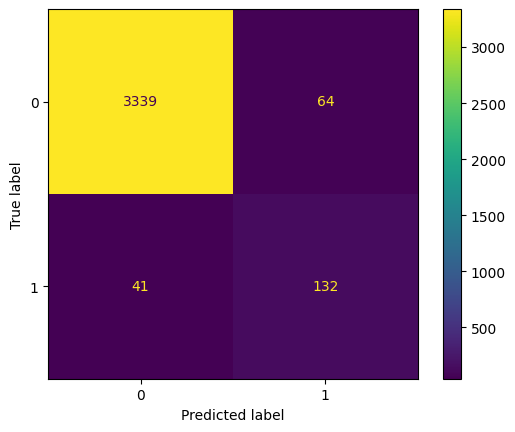

===== Multinomial Naive Bayes (Bag-of-Words) =====
Accuracy: 0.9706375838926175
Precision: 0.673469387755102
Recall: 0.7630057803468208
F1 Score: 0.7154471544715447
--------------------------------------------------

Top features indicative of fraudulent class: [('work', np.float64(-4.911127138865099)), ('experience', np.float64(-4.941764108326989)), ('skill', np.float64(-5.156608856826504)), ('service', np.float64(-5.221086161594799)), ('customer', np.float64(-5.390368709095772)), ('company', np.float64(-5.4763260119918105)), ('amp', np.float64(-5.485214959409057)), ('team', np.float64(-5.5429737935612495)), ('product', np.float64(-5.559322931562779)), ('position', np.float64(-5.574548139159845))]
Top features indicative of non-fraudulent class: [('experience', np.float64(-4.56217689599387)), ('team', np.float64(-4.75135359991749)), ('work', np.float64(-4.7623902422147)), ('false', np.float64(-4.853477918643373)), ('service', np.float64(-5.038832434467912)), ('company', np.float64(-5.

In [19]:
nb_model_bow = MultinomialNB(alpha=1.0)
nb_model_bow.fit(X_train_bow, y_train_bow)
y_pred_nb_bow = nb_model_bow.predict(X_test_bow)

cm = confusion_matrix(y_test_bow, y_pred_nb_bow)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model_bow.classes_)
disp.plot()
plt.show()
print("===== Multinomial Naive Bayes (Bag-of-Words) =====")
print("Accuracy:", accuracy_score(y_test_bow, y_pred_nb_bow))
print("Precision:", precision_score(y_test_bow, y_pred_nb_bow))
print("Recall:", recall_score(y_test_bow, y_pred_nb_bow))
print("F1 Score:", f1_score(y_test_bow, y_pred_nb_bow))
print("--------------------------------------------------\n")

fraudulent_importance = get_nb_feature_importance(nb_model_bow, bow_vectorizer, 1) # fraudulent class
non_fraudulent_importance = get_nb_feature_importance(nb_model_bow, bow_vectorizer, 0)
print("Top features indicative of fraudulent class:", fraudulent_importance[:10])
print("Top features indicative of non-fraudulent class:", non_fraudulent_importance[:10])

Model 2: Train Logistic Regression Model (Bag of Words)

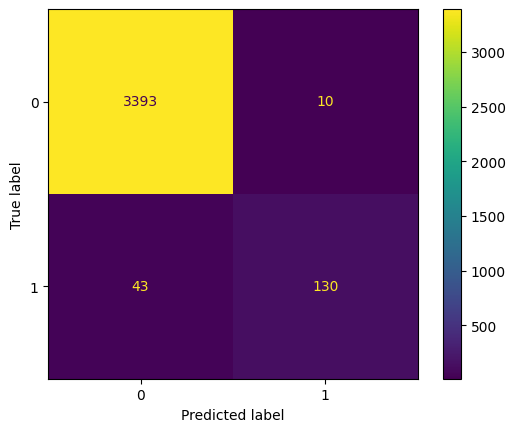

===== Logistic Regression (Bag-of-Words) =====
Accuracy: 0.985178970917226
Precision: 0.9285714285714286
Recall: 0.7514450867052023
F1 Score: 0.8306709265175719
------------------------------------------------

Top features indicative of fraudulent class: [('rohan', np.float64(1.100186077426551)), ('link', np.float64(0.9208702989853919)), ('aptitude', np.float64(0.886340418940354)), ('accion', np.float64(0.8044030119634954)), ('money', np.float64(0.776313454879884)), ('duration', np.float64(0.7565022954843794)), ('oriented', np.float64(0.7267074865149782)), ('wage', np.float64(0.7243897786415355)), ('accountant', np.float64(0.7230639721103065)), ('american', np.float64(0.6989618537784801))]
Top features indicative of non-fraudulent class: [('english', np.float64(-0.9616787642132713)), ('fun', np.float64(-0.6884318152819046)), ('startup', np.float64(-0.6872021676281915)), ('digital', np.float64(-0.6496102188298307)), ('exceptional', np.float64(-0.646750047307578)), ('become', np.float64

In [20]:
lr_model_bow = LogisticRegression(max_iter=1000)
lr_model_bow.fit(X_train_bow, y_train_bow)
y_pred_lr_bow = lr_model_bow.predict(X_test_bow)

cm = confusion_matrix(y_test_bow, y_pred_lr_bow)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model_bow.classes_)
disp.plot()
plt.show()
print("===== Logistic Regression (Bag-of-Words) =====")
print("Accuracy:", accuracy_score(y_test_bow, y_pred_lr_bow))
print("Precision:", precision_score(y_test_bow, y_pred_lr_bow))
print("Recall:", recall_score(y_test_bow, y_pred_lr_bow))
print("F1 Score:", f1_score(y_test_bow, y_pred_lr_bow))
print("------------------------------------------------\n")

feature_importance = lr_model_bow.coef_[0]
feature_names = bow_vectorizer.get_feature_names_out()
feature_importance_dict = dict(zip(feature_names, feature_importance))

sorted_importance_fraud = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)  # Sort descending
print("Top features indicative of fraudulent class:", sorted_importance_fraud[:10])

sorted_importance_non_fraud = sorted(feature_importance_dict.items(), key=lambda item: item[1]) #sort from smallest to largest.
print("Top features indicative of non-fraudulent class:", sorted_importance_non_fraud[:10])

Model 3: Train Deep Learning Model (Bag of Words)

In [ ]:
# Utility function to create a simple neural network model
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# Function to train and evaluate neural network models
def train_evaluate_nn(X_train, X_test, y_train, y_test, model_name):
    # Convert sparse matrices to dense arrays for Keras compatibility
    X_train_dense = X_train.toarray()
    X_test_dense = X_test.toarray()

    # Convert y_train and y_test to numpy arrays if they're pandas Series
    y_train_np = y_train.values if hasattr(y_train, 'values') else np.array(y_train)
    y_test_np = y_test.values if hasattr(y_test, 'values') else np.array(y_test)

    # Create model
    model = create_nn_model(X_train_dense.shape[1])

    # Set up early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        min_delta=0.001,
        restore_best_weights=True
    )

    # Calculate class weights (since data is imbalanced)
    # Fixed the class weight calculation to use numpy operations
    class_weight = {
        0: 1.0,
        1: np.sum(y_train_np == 0) / np.sum(y_train_np == 1)
    }

    # Train the model
    history = model.fit(
        X_train_dense, y_train_np,  # Use numpy array here
        epochs=10,
        batch_size=64,
        validation_split=0.1,
        callbacks=[early_stopping],
        class_weight=class_weight,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

    # Make predictions
    y_pred_prob = model.predict(X_test_dense)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Plot confusion matrix
    cm = confusion_matrix(y_test_np, y_pred)  # Use numpy array here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Print metrics
    print(f"===== {model_name} =====")
    print("Accuracy:", accuracy_score(y_test_np, y_pred))  # Use numpy array here
    print("Precision:", precision_score(y_test_np, y_pred))
    print("Recall:", recall_score(y_test_np, y_pred))
    print("F1 Score:", f1_score(y_test_np, y_pred))
    print("-" * 40 + "\n")

    return model, y_pred

Training Neural Network with Bag-of-Words features...
Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 248ms/step - accuracy: 0.9201 - loss: 0.9254 - val_accuracy: 0.9385 - val_loss: 0.1832
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.9582 - loss: 0.2122 - val_accuracy: 0.9665 - val_loss: 0.1212
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s 255ms/step - accuracy: 0.9794 - loss: 0.2074 - val_accuracy: 0.9734 - val_loss: 0.0866
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 50s 244ms/step - accuracy: 0.9927 - loss: 0.0509 - val_accuracy: 0.9776 - val_loss: 0.0985
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 50s 245ms/step - accuracy: 0.9964 - loss: 0.0249 - val_accuracy: 0.9804 - val_loss: 0.0984
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 51s 250ms/step - accuracy: 0.9964 - loss: 0.0923 - val_accuracy: 0.9825 - val_loss: 0.1233


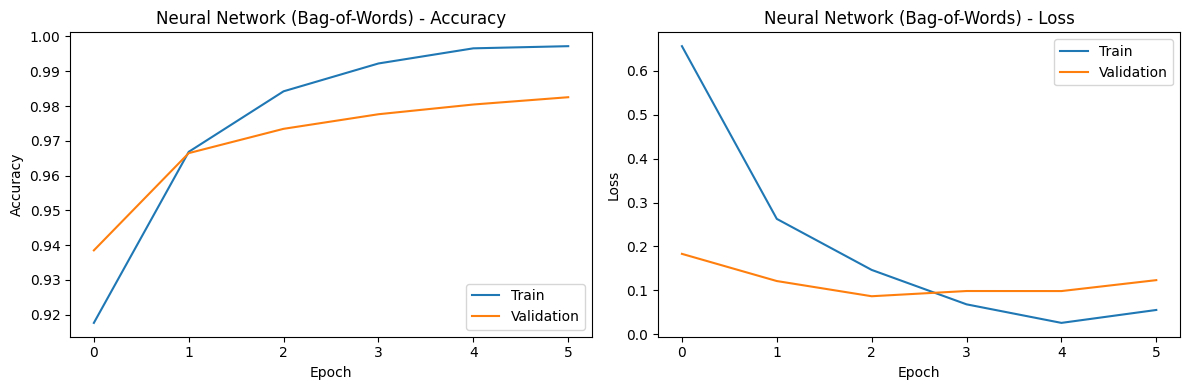

112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


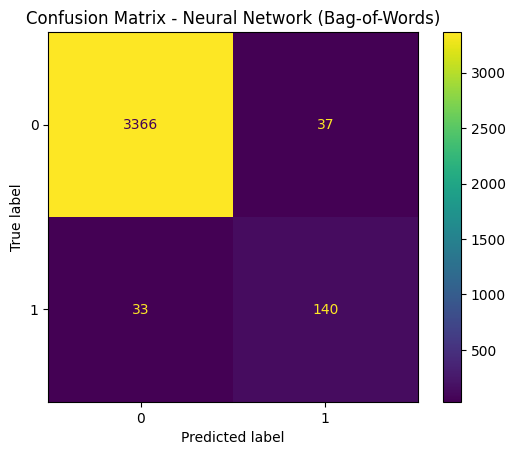

===== Neural Network (Bag-of-Words) =====
Accuracy: 0.9804250559284117
Precision: 0.7909604519774012
Recall: 0.8092485549132948
F1 Score: 0.8
----------------------------------------



In [ ]:
print("Training Neural Network with Bag-of-Words features...")
nn_model_bow, y_pred_nn_bow = train_evaluate_nn(
    X_train_bow, X_test_bow, y_train_bow, y_test_bow,
    "Neural Network (Bag-of-Words)"
)

# Testing Models Using TF-IDF Feature vectors

Model 1: Train Multinomial Bayes Model (TF-IDF)

In [21]:
# Train/Test Split for TF-IDF
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

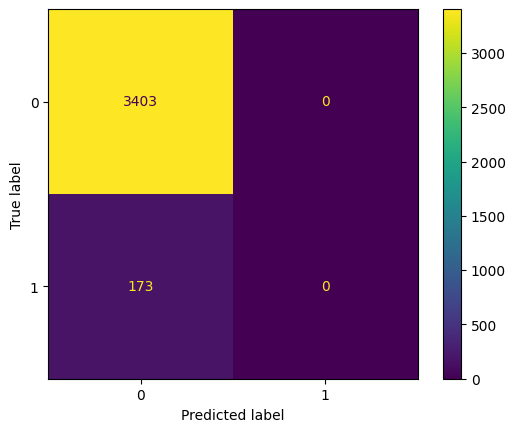

===== Multinomial Naive Bayes (TF-IDF) =====
Accuracy: 0.9516219239373602
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
--------------------------------------------------

Top features indicative of fraudulent class: [('work', np.float64(-11.051611680821111)), ('entry', np.float64(-11.147844177985217)), ('data entry', np.float64(-11.150015730963583)), ('skill', np.float64(-11.21203371586965)), ('customer', np.float64(-11.219366052748867)), ('position', np.float64(-11.225139461190171)), ('service', np.float64(-11.227552417190385)), ('home', np.float64(-11.244463812010189)), ('amp', np.float64(-11.29795951402513)), ('experience', np.float64(-11.301449838789395))]
Top features indicative of non-fraudulent class: [('experience', np.float64(-8.31427250588331)), ('team', np.float64(-8.461417432274821)), ('customer', np.float64(-8.469854362511493)), ('work', np.float64(-8.483410988634272)), ('job', np.float64(-8.527245701429875)), ('service', np.float64(-8.535416553010961)), ('company', np.float64

In [22]:
nb_model_tfidf = MultinomialNB(alpha=1.0)
nb_model_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_nb_tfidf = nb_model_tfidf.predict(X_test_tfidf)

cm = confusion_matrix(y_test_tfidf, y_pred_nb_tfidf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model_tfidf.classes_)
disp.plot()
plt.show()
print("===== Multinomial Naive Bayes (TF-IDF) =====")
print("Accuracy:", accuracy_score(y_test_tfidf, y_pred_nb_tfidf))
print("Precision:", precision_score(y_test_tfidf, y_pred_nb_tfidf))
print("Recall:", recall_score(y_test_tfidf, y_pred_nb_tfidf))
print("F1 Score:", f1_score(y_test_tfidf, y_pred_nb_tfidf))
print("--------------------------------------------------\n")

fraudulent_importance = get_nb_feature_importance(nb_model_tfidf, tfidf_vectorizer, 1)
non_fraudulent_importance = get_nb_feature_importance(nb_model_tfidf, tfidf_vectorizer, 0)
print("Top features indicative of fraudulent class:", fraudulent_importance[:10])
print("Top features indicative of non-fraudulent class:", non_fraudulent_importance[:10])

Model 2: Train Logistic Regression Model (TF-IDF)

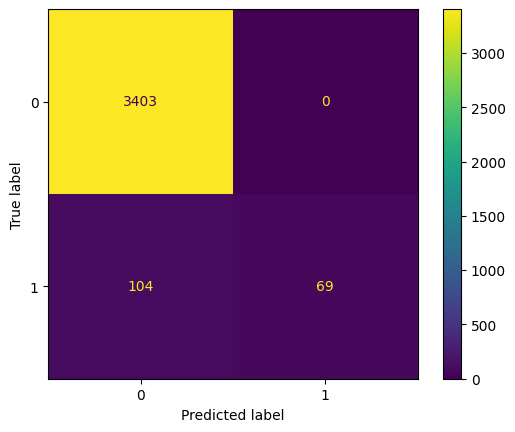

===== Logistic Regression (TF-IDF) =====
Accuracy: 0.970917225950783
Precision: 1.0
Recall: 0.3988439306358382
F1 Score: 0.5702479338842975
--------------------------------------------------
Top features indicative of fraudulent class: [('data entry', np.float64(3.1052691298682125)), ('entry', np.float64(2.6529486162046396)), ('administrative', np.float64(2.474857086597812)), ('assistant', np.float64(2.026609929156624)), ('earn', np.float64(1.9417269652734148)), ('phone', np.float64(1.9185481521633418)), ('administrative assistant', np.float64(1.7575704543674093)), ('accion', np.float64(1.753787591191628)), ('aker', np.float64(1.7509472363209158)), ('clerk', np.float64(1.7273898873071132))]
Top features indicative of non-fraudulent class: [('team', np.float64(-2.4322662191397617)), ('client', np.float64(-2.0065346192051603)), ('marketing', np.float64(-1.8371208185932484)), ('web', np.float64(-1.8092894814555922)), ('digital', np.float64(-1.5493397914580815)), ('software', np.float64(-1

In [23]:
# Logistic Regression (TF-IDF)
lr_model_tfidf = LogisticRegression(max_iter=1000)
lr_model_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_lr_tfidf = lr_model_tfidf.predict(X_test_tfidf)

cm = confusion_matrix(y_test_tfidf, y_pred_lr_tfidf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model_tfidf.classes_)
disp.plot()
plt.show()
print("===== Logistic Regression (TF-IDF) =====")
print("Accuracy:", accuracy_score(y_test_tfidf, y_pred_lr_tfidf))
print("Precision:", precision_score(y_test_tfidf, y_pred_lr_tfidf))
print("Recall:", recall_score(y_test_tfidf, y_pred_lr_tfidf))
print("F1 Score:", f1_score(y_test_tfidf, y_pred_lr_tfidf))
print("--------------------------------------------------")

feature_importance = lr_model_tfidf.coef_[0]
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_importance_dict = dict(zip(feature_names, feature_importance))

sorted_importance_fraud = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)  # Sort descending
print("Top features indicative of fraudulent class:", sorted_importance_fraud[:10])

sorted_importance_non_fraud = sorted(feature_importance_dict.items(), key=lambda item: item[1]) #sort from smallest to largest.
print("Top features indicative of non-fraudulent class:", sorted_importance_non_fraud[:10])

Model 3: Train Deep Learning Model (TF-IDF)

In [ ]:
# Deep Learning (TF-IDF)
print("Training Neural Network with TF-IDF features...")
nn_model_tfidf, y_pred_nn_tfidf = train_evaluate_nn(
    X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf,
    "Neural Network (TF-IDF)"
)

Training Neural Network with TF-IDF features...
Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 885s 4s/step - accuracy: 0.9220 - loss: 0.8725 - val_accuracy: 0.9588 - val_loss: 0.1167
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 878s 4s/step - accuracy: 0.9851 - loss: 0.0639 - val_accuracy: 0.9839 - val_loss: 0.0459
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 869s 4s/step - accuracy: 0.9991 - loss: 0.0106 - val_accuracy: 0.9846 - val_loss: 0.0421
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 872s 4s/step - accuracy: 0.9996 - loss: 0.0093 - val_accuracy: 0.9853 - val_loss: 0.0448
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 874s 4s/step - accuracy: 0.9997 - loss: 0.0035 - val_accuracy: 0.9811 - val_loss: 0.0547
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 867s 4s/step - accuracy: 0.9990 - loss: 0.0033 - val_accuracy: 0.9860 - val_loss: 0.0406
Epoch 7/10
 80/202 ━━━━━━━━━━━━━━━━━━━━ 8:39 4s/step - accuracy: 0.9997 - loss: 0.0011

# Lets try oversampling the minority (fraudlent) class now:

In [24]:
# from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)

# Fit and resample the training set to oversample the minority (fraudulent) class.
# X_train_bow_res, y_train_bow_res = ros.fit_resample(X_train_bow, y_train_bow)
X_train_bow_res, y_train_bow_res = smote.fit_resample(X_train_bow, y_train_bow)


Model 1: Train Multinomial Bayes Model + Oversampling (Bag of Words)

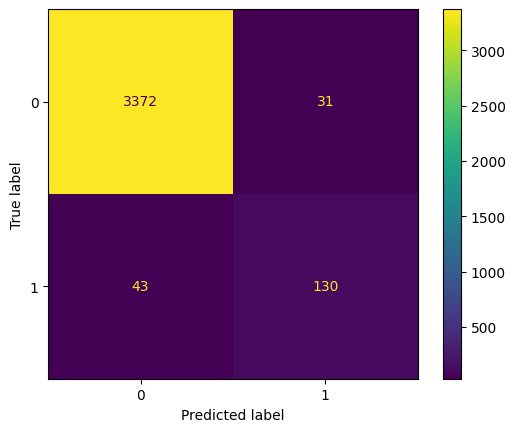

===== Multinomial Naive Bayes (Bag-of-Words) with Oversampled Training Data =====
Accuracy: 0.9793064876957495
Precision: 0.8074534161490683
Recall: 0.7514450867052023
F1 Score: 0.7784431137724551
--------------------------------------------------

Top features indicative of fraudulent class: [('work', np.float64(-4.23673784054143)), ('experience', np.float64(-4.35680297205818)), ('skill', np.float64(-4.561509169009611)), ('service', np.float64(-4.614107669999999)), ('customer', np.float64(-4.767421917501249)), ('amp', np.float64(-4.793218429262241)), ('product', np.float64(-4.876268413555014)), ('position', np.float64(-4.939702312795713)), ('team', np.float64(-4.949142579259808)), ('company', np.float64(-4.964049687608947))]
Top features indicative of non-fraudulent class: [('experience', np.float64(-4.56217689599387)), ('team', np.float64(-4.75135359991749)), ('work', np.float64(-4.7623902422147)), ('false', np.float64(-4.853477918643373)), ('service', np.float64(-5.038832434467912))

In [25]:
nb_model_bow_res = MultinomialNB(alpha=1.0)
nb_model_bow_res.fit(X_train_bow_res, y_train_bow_res)
y_pred_nb_bow_res = nb_model_bow_res.predict(X_test_bow)

cm = confusion_matrix(y_test_bow, y_pred_nb_bow_res)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model_bow_res.classes_)
disp.plot()
plt.show()
print("===== Multinomial Naive Bayes (Bag-of-Words) with Oversampled Training Data =====")
print("Accuracy:", accuracy_score(y_test_bow, y_pred_nb_bow_res))
print("Precision:", precision_score(y_test_bow, y_pred_nb_bow_res))
print("Recall:", recall_score(y_test_bow, y_pred_nb_bow_res))
print("F1 Score:", f1_score(y_test_bow, y_pred_nb_bow_res))
print("--------------------------------------------------\n")

fraudulent_importance = get_nb_feature_importance(nb_model_bow_res, bow_vectorizer, 1)
non_fraudulent_importance = get_nb_feature_importance(nb_model_bow_res, bow_vectorizer, 0)
print("Top features indicative of fraudulent class:", fraudulent_importance[:10])
print("Top features indicative of non-fraudulent class:", non_fraudulent_importance[:10])

Model 2: Train Logistic Regression + Oversampling (Bag of Words)

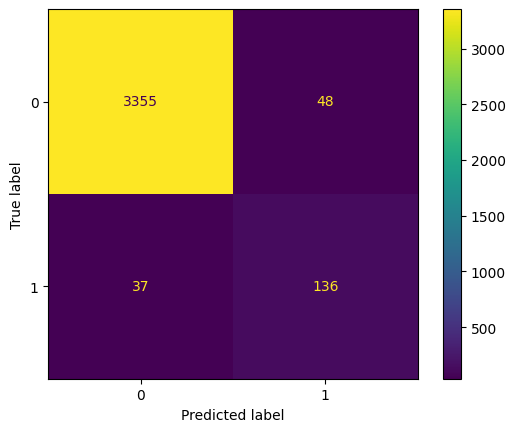

===== Logistic Regression (Bag-of-Words) with Oversampled Training Data =====
Accuracy: 0.9762304250559284
Precision: 0.7391304347826086
Recall: 0.7861271676300579
F1 Score: 0.7619047619047619
--------------------------------------------------

Top features indicative of fraudulent class: [('aptitude', np.float64(1.46413037654731)), ('accion', np.float64(1.26379944033401)), ('money', np.float64(1.0335114220930652)), ('american', np.float64(0.9567100175009848)), ('rideamigos', np.float64(0.904237018164829)), ('bw', np.float64(0.8978460644709377)), ('beverage', np.float64(0.8708869333035255)), ('link', np.float64(0.8638983795606858)), ('surgical', np.float64(0.8591066536869864)), ('ga', np.float64(0.8537805291931329))]
Top features indicative of non-fraudulent class: [('english', np.float64(-1.6012594735650156)), ('developer', np.float64(-1.3627008811231551)), ('specialist', np.float64(-1.276681352740138)), ('startup', np.float64(-1.2692145944231465)), ('university', np.float64(-1.255214

In [26]:
lr_model_bow_res = LogisticRegression(max_iter=1000)
lr_model_bow_res.fit(X_train_bow_res, y_train_bow_res)

# Predict on the original test set
y_pred_lr_bow_res = lr_model_bow_res.predict(X_test_bow)

# Evaluate the model
cm = confusion_matrix(y_test_bow, y_pred_lr_bow_res)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model_bow_res.classes_)
disp.plot()
plt.show()
print("===== Logistic Regression (Bag-of-Words) with Oversampled Training Data =====")
print("Accuracy:", accuracy_score(y_test_bow, y_pred_lr_bow_res))
print("Precision:", precision_score(y_test_bow, y_pred_lr_bow_res))
print("Recall:", recall_score(y_test_bow, y_pred_lr_bow_res))
print("F1 Score:", f1_score(y_test_bow, y_pred_lr_bow_res))
print("--------------------------------------------------\n")

feature_importance = lr_model_bow_res.coef_[0]
feature_names = bow_vectorizer.get_feature_names_out()
feature_importance_dict = dict(zip(feature_names, feature_importance))

sorted_importance_fraud = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)  # Sort descending
print("Top features indicative of fraudulent class:", sorted_importance_fraud[:10])

sorted_importance_non_fraud = sorted(feature_importance_dict.items(), key=lambda item: item[1]) #sort from smallest to largest.
print("Top features indicative of non-fraudulent class:", sorted_importance_non_fraud[:10])

Model 3: Train Deep Learning Model + Oversampling (Bag of Words)

In [ ]:
# Deep Learning (bag of words) with oversampled training data
print("Training Neural Network with Oversampled Bag-of-Words features...")
nn_model_bow_res, y_pred_nn_bow_res = train_evaluate_nn(
    X_train_bow_res, X_test_bow, y_train_bow_res, y_test_bow,
    "Neural Network (Bag-of-Words) with Oversampling"
)

Model 1: Train Multinomial Bayes Model + Oversampling (TF-IDF)

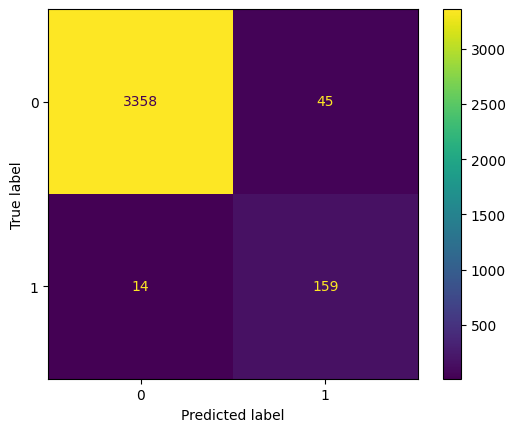

===== Multinomial Naive Bayes (TF-IDF) with Oversampled Training Data =====
Accuracy: 0.9835011185682326
Precision: 0.7794117647058824
Recall: 0.9190751445086706
F1 Score: 0.843501326259947
--------------------------------------------------

Top features indicative of fraudulent class: [('entry', np.float64(-8.289238304910526)), ('data entry', np.float64(-8.290619220895193)), ('work', np.float64(-8.293462216834696)), ('customer', np.float64(-8.42896232827976)), ('service', np.float64(-8.442358610246847)), ('skill', np.float64(-8.442401605511758)), ('position', np.float64(-8.46210869580489)), ('home', np.float64(-8.49305037756297)), ('data', np.float64(-8.525702319995595)), ('amp', np.float64(-8.539997524926804))]
Top features indicative of non-fraudulent class: [('experience', np.float64(-8.31427250588331)), ('team', np.float64(-8.461417432274821)), ('customer', np.float64(-8.469854362511493)), ('work', np.float64(-8.483410988634272)), ('job', np.float64(-8.527245701429875)), ('service

In [27]:
X_train_tfidf_res, y_train_tfidf_res = smote.fit_resample(X_train_tfidf, y_train_tfidf)

nb_model_tfidf_res = MultinomialNB(alpha=1.0)
nb_model_tfidf_res.fit(X_train_tfidf_res, y_train_tfidf_res)
y_pred_nb_tfidf_res = nb_model_tfidf_res.predict(X_test_tfidf)

cm = confusion_matrix(y_test_tfidf, y_pred_nb_tfidf_res)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model_tfidf_res.classes_)
disp.plot()
plt.show()
print("===== Multinomial Naive Bayes (TF-IDF) with Oversampled Training Data =====")
print("Accuracy:", accuracy_score(y_test_tfidf, y_pred_nb_tfidf_res))
print("Precision:", precision_score(y_test_tfidf, y_pred_nb_tfidf_res))
print("Recall:", recall_score(y_test_tfidf, y_pred_nb_tfidf_res))
print("F1 Score:", f1_score(y_test_tfidf, y_pred_nb_tfidf_res))
print("--------------------------------------------------\n")

fraudulent_importance = get_nb_feature_importance(nb_model_tfidf_res, tfidf_vectorizer, 1)
non_fraudulent_importance = get_nb_feature_importance(nb_model_tfidf_res, tfidf_vectorizer, 0)
print("Top features indicative of fraudulent class:", fraudulent_importance[:10])
print("Top features indicative of non-fraudulent class:", non_fraudulent_importance[:10])

Model 2: Train Logistic Regression + Oversampling (TF-IDF)

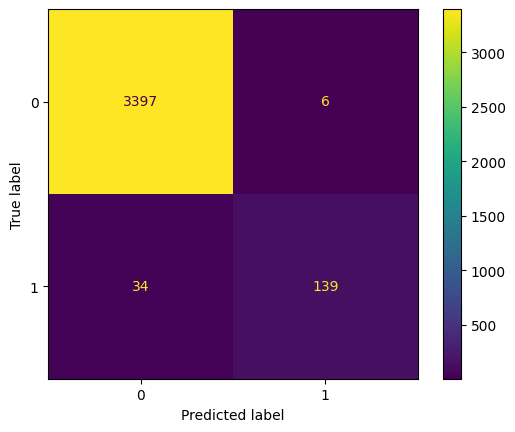

===== Logistic Regression (TF-IDF) with Oversampled Training Data =====
Accuracy: 0.9888143176733781
Precision: 0.9586206896551724
Recall: 0.8034682080924855
F1 Score: 0.8742138364779874
--------------------------------------------------

Top features indicative of fraudulent class: [('data entry', np.float64(4.8381069129683905)), ('entry', np.float64(4.107560458723805)), ('administrative', np.float64(3.6500160844139797)), ('accion', np.float64(3.5142057365966832)), ('assistant', np.float64(3.477524562056054)), ('phone', np.float64(3.4681095799306108)), ('earn', np.float64(3.4239485873509827)), ('clerk', np.float64(3.0622854521966216)), ('link url', np.float64(3.0301428649187025)), ('aker', np.float64(2.894468989781362))]
Top features indicative of non-fraudulent: [('team', np.float64(-3.8726700577119093)), ('client', np.float64(-3.5891827495350945)), ('web', np.float64(-2.899569197894909)), ('marketing', np.float64(-2.7599899782737567)), ('digital', np.float64(-2.6544892508225693)), (

In [28]:
lr_model_tfidf_res = LogisticRegression(max_iter=1000)
lr_model_tfidf_res.fit(X_train_tfidf_res, y_train_tfidf_res)
y_pred_lr_tfidf_res = lr_model_tfidf_res.predict(X_test_tfidf)

cm = confusion_matrix(y_test_tfidf, y_pred_lr_tfidf_res)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model_tfidf_res.classes_)
disp.plot()
plt.show()
print("===== Logistic Regression (TF-IDF) with Oversampled Training Data =====")
print("Accuracy:", accuracy_score(y_test_tfidf, y_pred_lr_tfidf_res))
print("Precision:", precision_score(y_test_tfidf, y_pred_lr_tfidf_res))
print("Recall:", recall_score(y_test_tfidf, y_pred_lr_tfidf_res))
print("F1 Score:", f1_score(y_test_tfidf, y_pred_lr_tfidf_res))
print("--------------------------------------------------\n")

feature_importance = lr_model_tfidf_res.coef_[0]
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_importance_dict = dict(zip(feature_names, feature_importance))

sorted_importance_fraud = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)  # Sort descending
print("Top features indicative of fraudulent class:", sorted_importance_fraud[:10])

sorted_importance_non_fraud = sorted(feature_importance_dict.items(), key=lambda item: item[1]) #sort from smallest to largest.
print("Top features indicative of non-fraudulent:", sorted_importance_non_fraud[:10])

Model 3: Train Deep Learning Model + Oversampling (Bag of Words)

In [ ]:
# Deep Learning (TF-IDF) with oversampled training data
print("Training Neural Network with Oversampled TF-IDF features...")
nn_model_tfidf_res, y_pred_nn_tfidf_res = train_evaluate_nn(
    X_train_tfidf_res, X_test_tfidf, y_train_tfidf_res, y_test_tfidf,
    "Neural Network (TF-IDF) with Oversampling"
)

# K-fold Cross Validation using Oversampled MultiNomialBayes and Logistic Regression Models

Model 1: Train Multinomial Bayes Model + Oversampling + K-fold CV (TF-IDF)

In [29]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mnb_model_tfidf = MultinomialNB(alpha=1.0)

# Evaluate the model using cross-validation on oversampled TF-IDF training data
cv_scores_mnb = cross_val_score(mnb_model_tfidf, X_train_tfidf_res, y_train_tfidf_res, cv=kfold, scoring='accuracy')

print("Accuracy scores for each fold (MNB):", cv_scores_mnb)
print("Mean Accuracy score (MNB):", cv_scores_mnb.mean())


Accuracy scores for each fold (MNB): [0.99210285 0.99008264 0.99228508 0.9904482  0.98842763]
Mean Accuracy score (MNB): 0.9906692804742366


Model 2: Train Logistic Regression Model + Oversampling + K-fold CV (TF-IDF)

In [30]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_model_tfidf = LogisticRegression(max_iter=1000)
cv_scores = cross_val_score(lr_model_tfidf, X_train_tfidf_res, y_train_tfidf_res, cv=kfold, scoring='accuracy')

print("Accuracy scores for each fold (MNB):", cv_scores_mnb)
print("Mean Accuracy score (MNB):", cv_scores_mnb.mean())


Accuracy scores for each fold (MNB): [0.99210285 0.99008264 0.99228508 0.9904482  0.98842763]
Mean Accuracy score (MNB): 0.9906692804742366
